In [1]:
import numpy as np
from scipy import signal
from scipy.signal import find_peaks
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import pycbc.waveform
from pycbc.waveform import get_td_waveform
from pycbc.waveform import get_fd_waveform
from pycbc.psd import estimate
from pycbc.types import TimeSeries
import emcee
import corner
import time
from multiprocessing import Pool
from multiprocessing import cpu_count

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


# loading in the unknown data

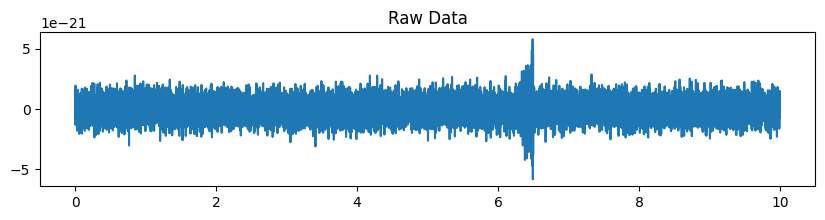

Text(0.5, 1.0, 'Raw Noise')

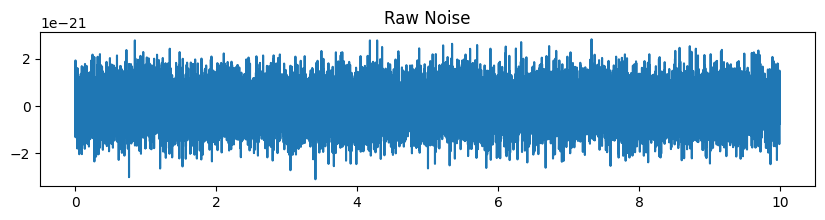

In [13]:
time_data, strain_data = np.loadtxt('data/PE_unknown_white_data_ts.txt',skiprows = 1).T
time_noise, strain_noise = np.loadtxt('data/PE_unknown_white_noise_ts.txt',skiprows=1).T
strain_noise_ts = TimeSeries(strain_noise, delta_t = time_noise[1]-time_noise[0])
strain_data_ts = TimeSeries(strain_data,delta_t=time_data[1]-time_data[0])


plt.figure(figsize = (10,2))
plt.plot(time_data,strain_data)
plt.title('Raw Data')
plt.show()

plt.figure(figsize= (10,2))
plt.plot(time_noise,strain_noise)
plt.title('Raw Noise')

# Sorting data so the window is applied when it is at the centre

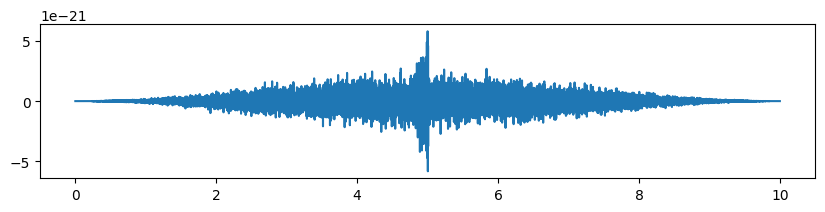

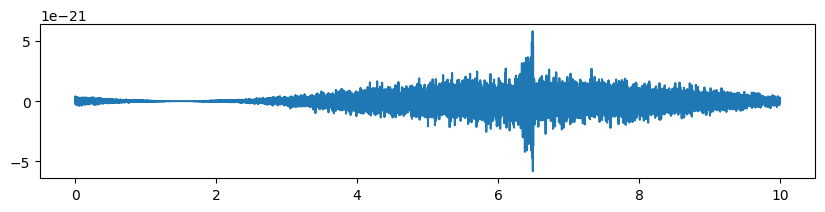

In [39]:
mid_point = len(strain_data) /2
final_point = len(strain_data)
peaks,_ = find_peaks(strain_data,height = 3e-21,distance = 1000)
roll_amount = mid_point - peaks
centred = np.roll(strain_data,int(roll_amount))
delta_t = time_data[1] - time_data[0]
duration = delta_t * len(strain_data)
window = signal.windows.hann(len(centred))
centred_windowed_signal = centred*window
centred_windowed_signal_final = np.roll(centred_windowed_signal,-int(roll_amount))

plt.figure(figsize = (10,2))
plt.plot(time_data,centred_windowed_signal)
plt.show()

plt.figure(figsize = (10,2))
plt.plot(time_data,centred_windowed_signal_final)
plt.show()


# converting to frequency space and cutting off unwanted frequencies

In [40]:
data_freq = np.fft.rfft(centred_windowed_signal_final) 
freq_array = np.fft.rfftfreq(len(time_data),delta_t)

delta_f = freq_array[1]-freq_array[0]

high_cutoff = 1000
low_cutoff = 30

high_limit = 800/delta_f+1
low_limit = 30/delta_f

data_final = data_freq[:int(high_limit)]
freq_final = freq_array[:int(high_limit)]

data_final[freq_final < low_cutoff] = 0 

#defing psd
delta_t = time_data[1] - time_data[0]
duration = len(strain_data)*delta_t
seg_len = len(strain_noise_ts) // 4
seg_stride = seg_len // 2

psd = estimate.welch(strain_noise_ts,window = 'hann' ,seg_len=seg_len,seg_stride = seg_stride)
psd_freqs = np.fft.fftfreq(len(psd), d=delta_t)  

interp_psd = interp1d(psd_freqs, psd, kind='linear', bounds_error=False, fill_value="extrapolate")
psd_interpolated = interp_psd(freq_array[:int(high_limit)]) 

In [61]:
def template(theta,delta_t,delta_f,time_shift):
    M1,M2,D = theta 

    hplus , hc = get_fd_waveform(mass1 = M1,mass2 = M2,distance = D,approximant='IMRPhenomPv2',f_lower=30, f_higher=1000, delta_t = delta_t, delta_f = delta_f)
    
    hplus= hplus.cyclic_time_shift(time_shift)

    if len(hplus) > len(data_final):
        hplus = hplus[:len(data_final)]
    return hplus

In [65]:
def log_prior(theta):
    M1,M2,D = theta
    if 30 < M1 < 34 and 28 < M2 < M1 and 80 < D < 150:#and 0 < time_shift < 10:# and 0 < f_lower < 100 and f_lower < f_higher < 1000:
        return 2*np.log(D)
    return -np.inf

In [66]:
def log_like(theta, fft_signal,noise ,delta_t,delta_f):

    
    temp = template(theta, delta_t,delta_f,8)

    residual = fft_signal*delta_t - temp*delta_t
    sum = np.abs(residual)**2/noise
    return -2 / duration * np.sum((sum).numpy())

In [67]:
def log_posterior(theta, data,noise_data,delta_t,delta_f):
    # print(f"Theta: {theta}")
    log_pri = log_prior(theta)
    if np.isinf(log_pri):  # if prior is -inf, return stragiht away
        return log_pri
    return log_pri + log_like(theta, data, noise_data,delta_t,delta_f)

In [68]:
nwalkers = 10
ndim = 3

# defining intitial array of guess (theta guesses)
initial = np.empty((nwalkers, ndim)) 
initial[:, 0] = np.random.uniform(20, 60, size=nwalkers)
initial[:, 1] = np.random.uniform(10, initial[:, 0])
initial[:, 2] = np.random.uniform(80, 600, size=nwalkers)
# initial[:, 3] = np.random.uniform(0, 10, size=nwalkers)
# initial[:, 4] = np.random.uniform(0, 100, size=nwalkers)
# initial[:, 5] = np.random.uniform(initial[:,4], 2000, size=nwalkers)


#running the emcee sampelr
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(data_final,psd_interpolated,delta_t,delta_f))#,moves= emcee.moves.StretchMove())

#running the burn - in stage of the mcmc chain to allow the walker tp explore the space
state = sampler.run_mcmc(initial, nsteps = 1000,progress = True)
sampler.reset()
# running the mcmc
nsteps = 1000
sampler.run_mcmc(initial, nsteps,progress = True)

  0%|          | 0/1000 [00:00<?, ?it/s]/Users/maxrobertson/code/Grav Waves/venv/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 1000/1000 [00:00<00:00, 2266.38it/s]


State([[ 43.41911586  13.09109921 151.67310553]
 [ 29.60642236  26.66996624 479.74684834]
 [ 42.60138143  14.94086029 215.41554615]
 [ 44.04883044  34.14120975 535.16473317]
 [ 33.28477151  19.2750225  403.93893326]
 [ 23.22741413  10.27726658 584.27385313]
 [ 27.16167721  12.59244567 163.80923385]
 [ 43.41459438  39.99488281 265.76102734]
 [ 22.09786691  13.62799923 190.08548536]
 [ 58.93625276  37.44060109 283.96510538]], log_prob=[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf], blobs=None, random_state=('MT19937', array([1767017870, 1204482079, 1750312277, 4043326297,  717555922,
       2771289974, 2063509197, 1841941355, 2473290913, 1779953548,
       3928659011, 2923590249,   21597207,  830546425, 3425543966,
       4292134305, 3362900088, 4233329040, 1209116916, 2657637736,
        449647244, 1374515769,  198076016, 3898976581,  695338027,
        402563304, 1381429129, 1939848819, 2606469462, 3481951920,
       1072769458, 3951652963, 1139308343,  412607502,  657118139,
    

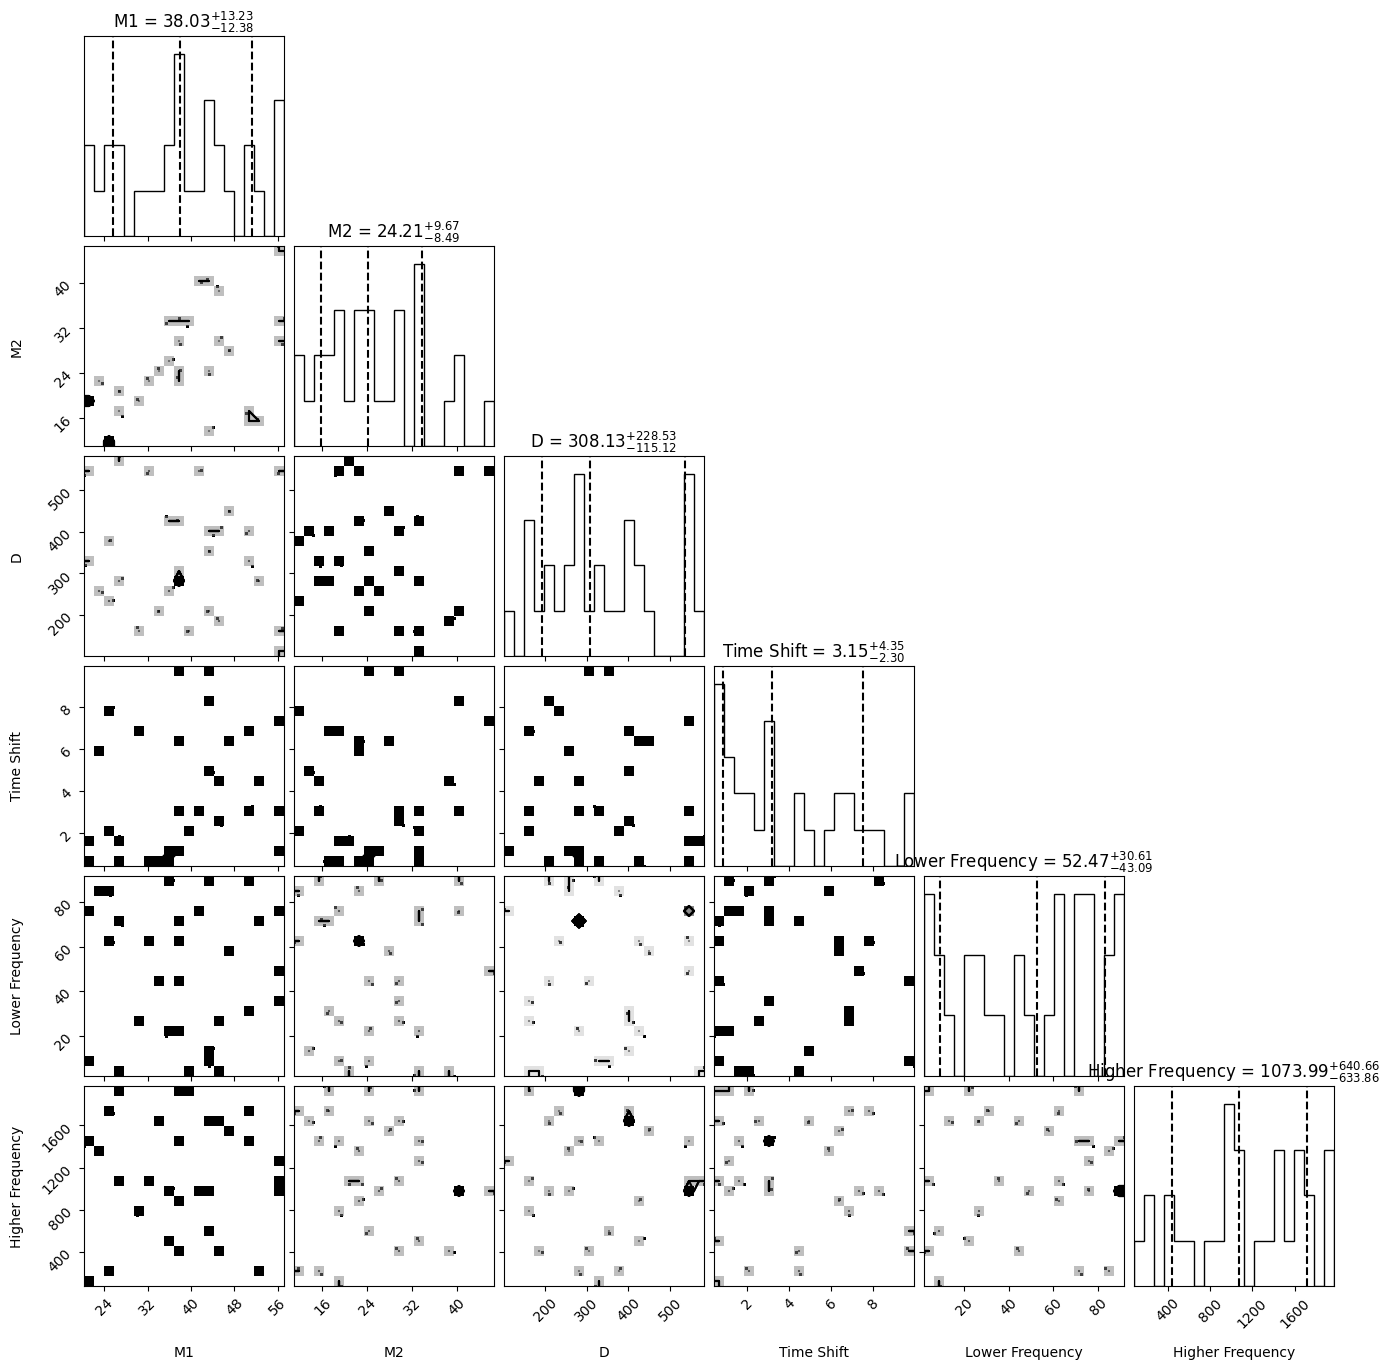

In [36]:
samples = sampler.flatchain


figure = corner.corner(samples,labels = ['M1','M2','D','Time Shift', 'Lower Frequency','Higher Frequency'],quantiles=[0.16,0.5,0.84],show_titles = True)